In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil
import copy

from scipy import ndimage, interpolate, optimize

from eos import aqua_eos, fe_eos
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

# H: blend CMS19 and Mazevet+2022

In [2]:
maz_H = meos.mazevet2022table("./CEPAM/mazevet2020/H-Table-Tristan-Yamila.dat",units='cgs')
cms_H = meos.CMStable("./2021_chabrier+_tables/TABLE_H_Trho_v1",units='cgs')

maz_H_attr_list = dir(maz_H)
cms_H_attr_list = dir(cms_H)

maz_H_attr_list_filtered = []
for i, li in enumerate(maz_H_attr_list):
    if li[0] != "_":
        maz_H_attr_list_filtered.append(li)

cms_H_attr_list_filtered = []
for i, li in enumerate(cms_H_attr_list):
    if li[0] != "_":
        cms_H_attr_list_filtered.append(li)
        
print(maz_H_attr_list_filtered)
print(cms_H_attr_list_filtered)

# maz_H is (T, rho)
#  log10T ranges from 2.11 to 4.91 in steps of 0.1
#  log10rho ranges from -9. to 1. steps of 0.01
#
# cms_H is (T, rho)
#  log10T ranges from 2. to 8. in steps of 0.05 (121 entries)
#  log10rho ranges from -8. to 6. in steps of 0.05 (281 entries)
#

['X', 'Y', 'atomic_number', 'eosData', 'filename', 'independent_arr_1', 'independent_arr_2', 'independent_var_1', 'independent_var_2', 'log10Egrid', 'log10Pgrid', 'log10Sgrid', 'log10Tgrid', 'log10Ugrid', 'log10rhogrid', 'mass_number', 'units']
['Cp', 'Cv', 'X', 'Y', 'atomic_number', 'chiRho', 'chiT', 'compute_F_table', 'compute_partials', 'dE_drho_T', 'dE_drho_T_direct', 'dS_dT_rho', 'dS_dT_rho_direct', 'dS_drho_T', 'dS_drho_T_direct', 'dlE_dlrho_T', 'dlS_dlT_rho', 'dlS_dlrho_T', 'eosData', 'eta', 'filename', 'gamma1', 'gamma3', 'grad_ad', 'independent_arr_1', 'independent_arr_2', 'independent_var_1', 'independent_var_2', 'log10Egrid', 'log10Pgrid', 'log10Qgrid', 'log10Sgrid', 'log10Tgrid', 'log10Ugrid', 'log10rhogrid', 'log_free_e', 'mass_number', 'mu', 'units']


/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:1001: RuntimeWarning: invalid value encountered in log10
  eosdata = np.log10(eosdata)


In [3]:
bln_H = meos.simple_table()
bln_H.X = 1.
bln_H.Y = 0.

bln_H.atomic_number = bln_H.X + 2*(1.-bln_H.X)
bln_H.mass_number = bln_H.X + 4*(1.-bln_H.X) 

maz_T = maz_H.independent_arr_1
maz_rho = maz_H.independent_arr_2

cms_T = cms_H.independent_arr_1
cms_rho = cms_H.independent_arr_2

# interpolate Mazevet EoS quantities to the CMS grid

# for the mazevet log10S grid, fill in nans with the minimum value found elsewhere in the table (this is all in the unphysical zone of parameter space anyway)
maz_H_log10Sgrid_noNans = meos.fill_in_nans(maz_H.log10Sgrid, maz_H)

interp_log10P_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(maz_rho, maz_T), values=maz_H.log10Pgrid, bounds_error=False, fill_value=None, method='linear')
interp_log10S_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(maz_rho, maz_T), values=maz_H_log10Sgrid_noNans, bounds_error=False, fill_value=None, method='linear')
interp_log10U_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(maz_rho, maz_T), values=maz_H.log10Ugrid, bounds_error=False, fill_value=None, method='linear')


bln_H.log10Tgrid = copy.deepcopy(cms_H.log10Tgrid)
bln_H.log10rhogrid = copy.deepcopy(cms_H.log10rhogrid)

# blended grid will be identical to CMS grid in the parameter space that Mazevet 2022 table doesn't cover.
# where the tables overlap, substitute interpolated Mazevet quantities into the CMS grid
blended_log10Pgrid = copy.deepcopy(cms_H.log10Pgrid)
blended_log10Sgrid = copy.deepcopy(cms_H.log10Sgrid)
blended_log10Ugrid = copy.deepcopy(cms_H.log10Ugrid)
        
for i in range(0,181):
    for j in range(3,60):
        blended_log10Pgrid[i,j] = interp_log10P_given_log10rho_log10T_cubic((bln_H.log10rhogrid[i,j], bln_H.log10Tgrid[i,j]))
        blended_log10Sgrid[i,j] = interp_log10S_given_log10rho_log10T_cubic((bln_H.log10rhogrid[i,j], bln_H.log10Tgrid[i,j]))
        blended_log10Ugrid[i,j] = interp_log10U_given_log10rho_log10T_cubic((bln_H.log10rhogrid[i,j], bln_H.log10Tgrid[i,j]))

# blend edges of interpolation region
blended_log10Pgrid[180,3:60] = 0.5*(blended_log10Pgrid[179,3:60] + blended_log10Pgrid[181,3:60])
blended_log10Sgrid[180,3:60] = 0.5*(blended_log10Sgrid[179,3:60] + blended_log10Sgrid[181,3:60])
blended_log10Ugrid[180,3:60] = 0.5*(blended_log10Ugrid[179,3:60] + blended_log10Ugrid[181,3:60])

blended_log10Pgrid[:181,3] = 0.5*(blended_log10Pgrid[:181,2] + blended_log10Pgrid[:181,4])
blended_log10Sgrid[:181,3] = 0.5*(blended_log10Sgrid[:181,2] + blended_log10Sgrid[:181,4])
blended_log10Ugrid[:181,3] = 0.5*(blended_log10Ugrid[:181,2] + blended_log10Ugrid[:181,4])

blended_log10Pgrid[:181,59] = 0.5*(blended_log10Pgrid[:181,58] + blended_log10Pgrid[:181,60])
blended_log10Sgrid[:181,59] = 0.5*(blended_log10Sgrid[:181,58] + blended_log10Sgrid[:181,60])
blended_log10Ugrid[:181,59] = 0.5*(blended_log10Ugrid[:181,58] + blended_log10Ugrid[:181,60])
        
bln_H.log10Pgrid = blended_log10Pgrid
bln_H.log10Sgrid = blended_log10Sgrid
bln_H.log10Egrid = blended_log10Ugrid
bln_H.log10Ugrid = bln_H.log10Egrid

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_59182/2913039998.py:53: RuntimeWarning: divide by zero encountered in log10
  log10P_reldiff = np.log10(np.abs((cms_H.log10Pgrid - bln_H.log10Pgrid)/cms_H.log10Pgrid))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_59182/2913039998.py:54: RuntimeWarning: divide by zero encountered in log10
  log10S_reldiff = np.log10(np.abs((cms_H.log10Sgrid - bln_H.log10Sgrid)/cms_H.log10Sgrid))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_59182/2913039998.py:55: RuntimeWarning: divide by zero encountered in log10
  log10U_reldiff = np.log10(np.abs((cms_H.log10Ugrid - bln_H.log10Ugrid)/cms_H.log10Ugrid))


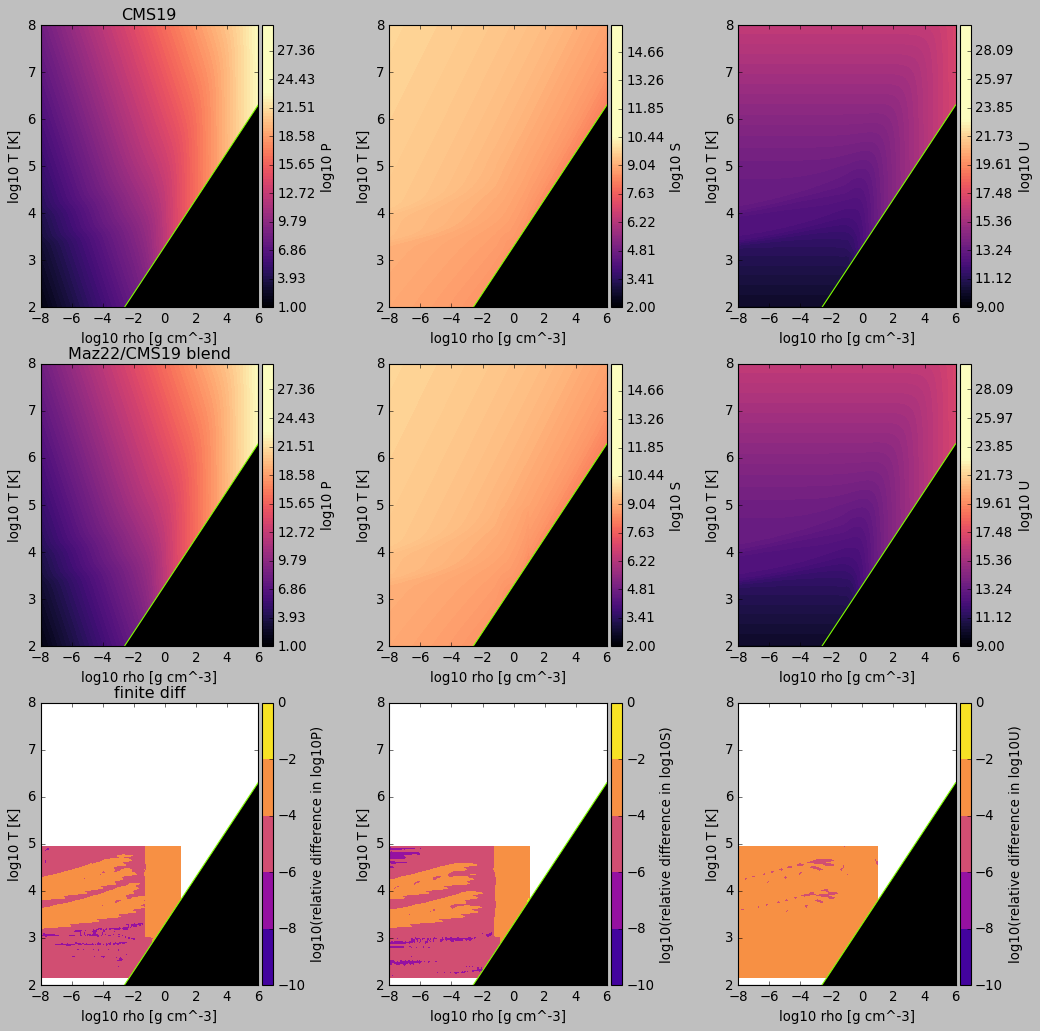

In [4]:
Plevels = np.linspace(1.,30., 100)
Pvmin = 1
Pvmax = 23.0

Slevels = np.linspace(2., 16., 200)
Svmin = 2
Svmax = 10.5

Ulevels = np.linspace(9., 30., 100)
Uvmin = 9.
Uvmax = 23.0

diffvmin = -10
diffvmax = -0.5
difflevels = np.linspace(diffvmin,0,6)


fig, axes = plt.subplots(3,3,figsize=(15,15))

# row 0: original CMS
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: blend
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')


log10P_reldiff = np.log10(np.abs((cms_H.log10Pgrid - bln_H.log10Pgrid)/cms_H.log10Pgrid))
log10S_reldiff = np.log10(np.abs((cms_H.log10Sgrid - bln_H.log10Sgrid)/cms_H.log10Sgrid))
log10U_reldiff = np.log10(np.abs((cms_H.log10Ugrid - bln_H.log10Ugrid)/cms_H.log10Ugrid))

# row 2: finite diff
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10P_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10(relative difference in log10P)')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10S_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10(relative difference in log10S)')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10U_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10(relative difference in log10U)')

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

axes[0,0].set_title("CMS19")

axes[1,0].set_title("Maz22/CMS19 blend")
axes[2,0].set_title("finite diff")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [5]:
bln_H.compute_partials(species='H')

/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:292: RuntimeWarning: overflow encountered in power
  self.dP_drho, self.dS_drho, self.dE_drho, self.dP_dT, self.dS_dT, self.dE_dT = finite_difference_PSE(self, 10**self.log10Pgrid, 10**self.log10Sgrid, 10**self.log10Egrid, species=species, maskUnphysicalRegion=False, plot=False, savename=None)
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:295: RuntimeWarning: overflow encountered in power
  self.dlS_dlrho_T = self.dS_drho * (10**self.log10rhogrid/10**self.log10Sgrid)
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:296: RuntimeWarning: overflow encountered in power
  self.dlE_dlrho_T = self.dE_drho * (10**self.log10rhogrid/10**self.log10Egrid)
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:299: RuntimeWarning: overflow encountered in power
  self.dlS_dlT_rho = self.dS_dT * (10**self.log10Tgrid/10**self.

In [6]:
# check for smoothness

# clearly there are some discontinuities, particularly in chiT, at the edge of the blended region. let's replace the outermost rows/column of the blended region with linearly interpolated values
chiRho_smoothed = copy.deepcopy(bln_H.chiRho)
dlS_dlrho_T_smoothed = copy.deepcopy(bln_H.dlS_dlrho_T)
dlE_dlrho_T_smoothed = copy.deepcopy(bln_H.dlE_dlrho_T)
chiT_smoothed = copy.deepcopy(bln_H.chiT)
dlS_dlT_rho_smoothed = copy.deepcopy(bln_H.dlS_dlT_rho)


rho_smoothing_width = 2

for ii, i in enumerate(range(180-rho_smoothing_width, 180+rho_smoothing_width+1)):
    chiRho_smoothed[i, 3:60] =  chiRho_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiRho_smoothed[180 + rho_smoothing_width + 1, 3:60] - chiRho_smoothed[180 - rho_smoothing_width - 1, 3:60])
    dlS_dlrho_T_smoothed[i, 3:60] =  dlS_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlrho_T_smoothed[180 + rho_smoothing_width + 1, 3:60] - dlS_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60])
    dlE_dlrho_T_smoothed[i, 3:60] =  dlE_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlE_dlrho_T_smoothed[180 + rho_smoothing_width + 1, 3:60] - dlE_dlrho_T_smoothed[180 - rho_smoothing_width - 1, 3:60])
    
    chiT_smoothed[i, 3:60] =  chiT_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiT_smoothed[180 + rho_smoothing_width + 1, 3:60] - chiT_smoothed[180 - rho_smoothing_width - 1, 3:60])
    dlS_dlT_rho_smoothed[i, 3:60] =  dlS_dlT_rho_smoothed[180 - rho_smoothing_width - 1, 3:60] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlT_rho_smoothed[180 + rho_smoothing_width + 1, 3:60] - dlS_dlT_rho_smoothed[180 - rho_smoothing_width - 1, 3:60])

T_smoothing_width = 2

for jj, j in enumerate(range(59-T_smoothing_width, 59+T_smoothing_width+1)):
    chiRho_smoothed[:181,j] = chiRho_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiRho_smoothed[:181,59+T_smoothing_width+1] - chiRho_smoothed[:181,59-T_smoothing_width - 1])
    dlS_dlrho_T_smoothed[:181,j] = dlS_dlrho_T_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlrho_T_smoothed[:181,59+T_smoothing_width+1] - dlS_dlrho_T_smoothed[:181,59-T_smoothing_width - 1])
    dlE_dlrho_T_smoothed[:181,j] = dlE_dlrho_T_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlE_dlrho_T_smoothed[:181,59+T_smoothing_width+1] - dlE_dlrho_T_smoothed[:181,59-T_smoothing_width - 1])
    
    chiT_smoothed[:181,j] = chiT_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiT_smoothed[:181,59+T_smoothing_width+1] - chiT_smoothed[:181,59-T_smoothing_width - 1])
    dlS_dlT_rho_smoothed[:181,j] = dlS_dlT_rho_smoothed[:181,59-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlT_rho_smoothed[:181,59+T_smoothing_width+1] - dlS_dlT_rho_smoothed[:181,59-T_smoothing_width - 1])
    
# for the lower T boundary, we're very close to the edge of the grid, so only smooth over 1 row to avoid using the extrapolated edge value in the smoothing
chiRho_smoothed[:181,3] = 0.5*(chiRho_smoothed[:181,2] + chiRho_smoothed[:181,4])
dlS_dlrho_T_smoothed[:181,3] = 0.5*(dlS_dlrho_T_smoothed[:181,2] + dlS_dlrho_T_smoothed[:181,4])
dlE_dlrho_T_smoothed[:181,3] = 0.5*(dlE_dlrho_T_smoothed[:181,2] + dlE_dlrho_T_smoothed[:181,4])

chiT_smoothed[:181,3] = 0.5*(chiT_smoothed[:181,2] + chiT_smoothed[:181,4])
dlS_dlT_rho_smoothed[:181,3] = 0.5*(dlS_dlT_rho_smoothed[:181,2] + dlS_dlT_rho_smoothed[:181,4])


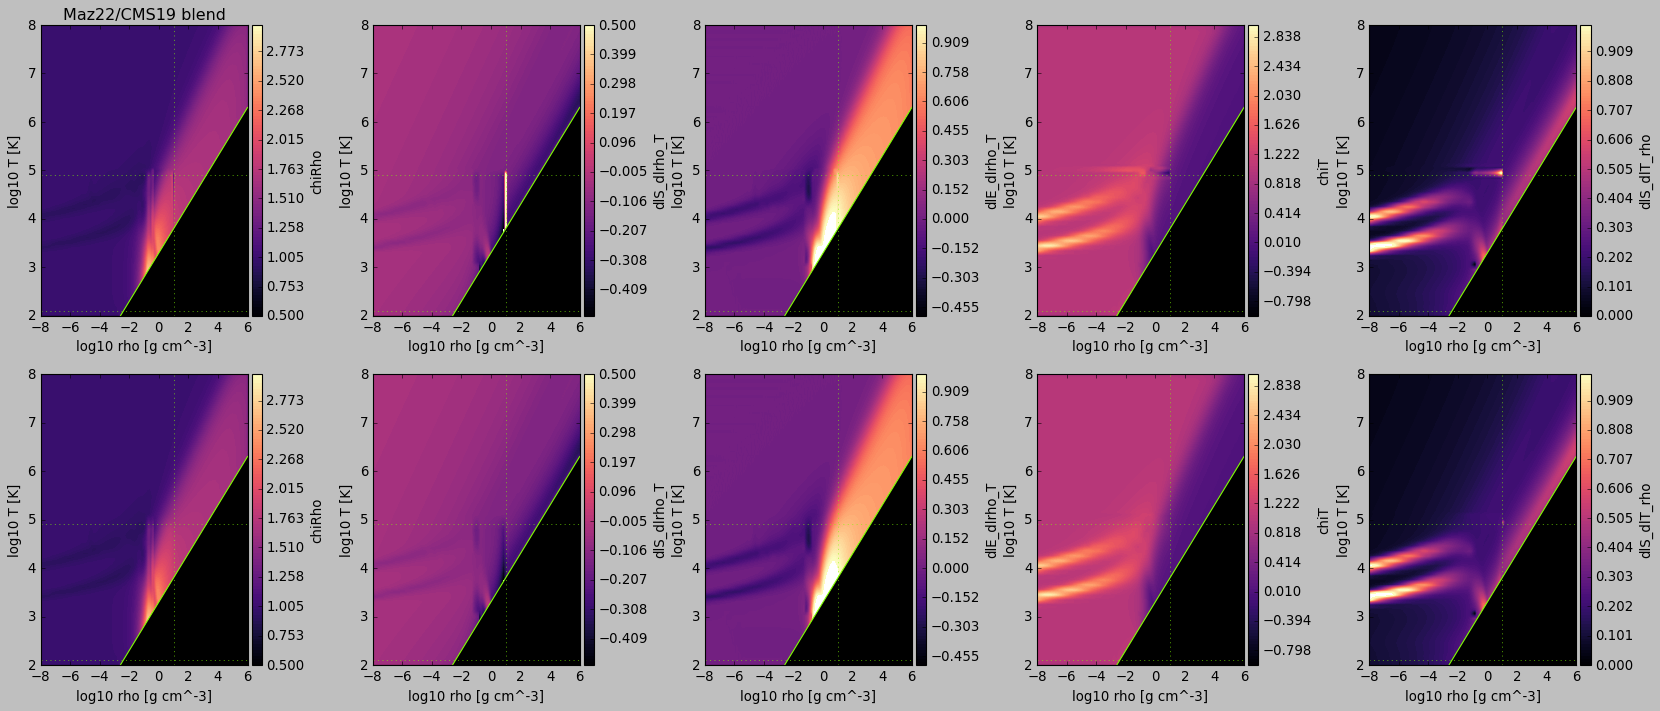

In [7]:
chiRho_vmin = 0.5
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -0.5
dlS_dlrho_T_vmax =0.5
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -0.5
dlE_dlrho_T_vmax =1
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)


chiT_vmin = -1
chiT_vmax = 3
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = 0
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')




# row 1: interpolated finite difference quantities from bln_H table, with linearly smoothed edges of the blended region
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')


for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(1,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.1,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.91,color='#7FFF00',lw=0.5,ls=':')

axes[0,0].set_title("Maz22/CMS19 blend")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [8]:
# ok, satisfied with that smoothing for now--put it in the table object
bln_H.chiRho = chiRho_smoothed
bln_H.dlS_dlrho_T = dlS_dlrho_T_smoothed
bln_H.dlE_dlrho_T = dlE_dlrho_T_smoothed
bln_H.chiT = chiT_smoothed
bln_H.dlS_dlT_rho = dlS_dlT_rho_smoothed


In [9]:
# compute F
bln_H.compute_F_table()

/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:192: RuntimeWarning: overflow encountered in power
  Fgrid = 10**table.log10Egrid - ((10**table.log10Tgrid) * (10**table.log10Sgrid))
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:192: RuntimeWarning: invalid value encountered in subtract
  Fgrid = 10**table.log10Egrid - ((10**table.log10Tgrid) * (10**table.log10Sgrid))
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:287: RuntimeWarning: invalid value encountered in log10
  self.F_log10Pgrid = np.log10(self.F_Pgrid)
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:288: RuntimeWarning: invalid value encountered in log10
  self.F_log10Sgrid = np.log10(self.F_Sgrid)
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:289: RuntimeWarning: invalid value encountered in log10
  self.F_log10Egrid = np.log10(self.F_Egrid)


In [10]:
outfile = open("./cms19_mazevet2022_H_blend.pkl","wb")
pickle.dump(bln_H,outfile)
outfile.close()

# He: interpolate over bad columns

In [11]:
cms19_He = meos.CMStable("./2021_chabrier+_tables/TABLE_HE_Trho_v1",units='cgs',F_smoothing_kernel=1)
new_P, new_S, new_E = meos.interpolate_problematic_values(cms19_He,bad_rho_idxs=np.arange(193,203), bad_T_idxs=[79,80,81])
cms19_He.log10Ptable = new_P
cms19_He.log10Stable = new_S
cms19_He.log10Etable = new_E
cms19_He.log10Utable = new_E

cms19_He.compute_partials(species='He')

In [12]:
# linearly interpolate over the column log10rho = 2 and the row log10T = 6
chiRho_smoothed = copy.deepcopy(cms19_He.chiRho)
dlS_dlrho_T_smoothed = copy.deepcopy(cms19_He.dlS_dlrho_T)
dlE_dlrho_T_smoothed = copy.deepcopy(cms19_He.dlE_dlrho_T)
chiT_smoothed = copy.deepcopy(cms19_He.chiT)
dlS_dlT_rho_smoothed = copy.deepcopy(cms19_He.dlS_dlT_rho)


rho_smoothing_width = 4

for ii, i in enumerate(range(200-rho_smoothing_width, 200+rho_smoothing_width+1)):
    chiRho_smoothed[i, 40:80] =  chiRho_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiRho_smoothed[200 + rho_smoothing_width + 1, 40:80] - chiRho_smoothed[200 - rho_smoothing_width - 1, 40:80])
    dlS_dlrho_T_smoothed[i, 40:80] =  dlS_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlrho_T_smoothed[200 + rho_smoothing_width + 1, 40:80] - dlS_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80])
    dlE_dlrho_T_smoothed[i, 40:80] =  dlE_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlE_dlrho_T_smoothed[200 + rho_smoothing_width + 1, 40:80] - dlE_dlrho_T_smoothed[200 - rho_smoothing_width - 1, 40:80])
    
    chiT_smoothed[i, 40:80] =  chiT_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(chiT_smoothed[200 + rho_smoothing_width + 1, 40:80] - chiT_smoothed[200 - rho_smoothing_width - 1, 40:80])
    dlS_dlT_rho_smoothed[i, 40:80] =  dlS_dlT_rho_smoothed[200 - rho_smoothing_width - 1, 40:80] + ((ii+1)/(2*rho_smoothing_width + 2))*(dlS_dlT_rho_smoothed[200 + rho_smoothing_width + 1, 40:80] - dlS_dlT_rho_smoothed[200 - rho_smoothing_width - 1, 40:80])

T_smoothing_width = 3

for jj, j in enumerate(range(80-T_smoothing_width, 80+T_smoothing_width+1)):
    chiRho_smoothed[140:200,j] = chiRho_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiRho_smoothed[140:200,80+T_smoothing_width+1] - chiRho_smoothed[140:200,80-T_smoothing_width - 1])
    dlS_dlrho_T_smoothed[140:200,j] = dlS_dlrho_T_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlrho_T_smoothed[140:200,80+T_smoothing_width+1] - dlS_dlrho_T_smoothed[140:200,80-T_smoothing_width - 1])
    dlE_dlrho_T_smoothed[140:200,j] = dlE_dlrho_T_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlE_dlrho_T_smoothed[140:200,80+T_smoothing_width+1] - dlE_dlrho_T_smoothed[140:200,80-T_smoothing_width - 1])
    
    chiT_smoothed[140:200,j] = chiT_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(chiT_smoothed[140:200,80+T_smoothing_width+1] - chiT_smoothed[140:200,80-T_smoothing_width - 1])
    dlS_dlT_rho_smoothed[140:200,j] = dlS_dlT_rho_smoothed[140:200,80-T_smoothing_width-1] + ((jj+1)/(2*T_smoothing_width+2))*(dlS_dlT_rho_smoothed[140:200,80+T_smoothing_width+1] - dlS_dlT_rho_smoothed[140:200,80-T_smoothing_width - 1])


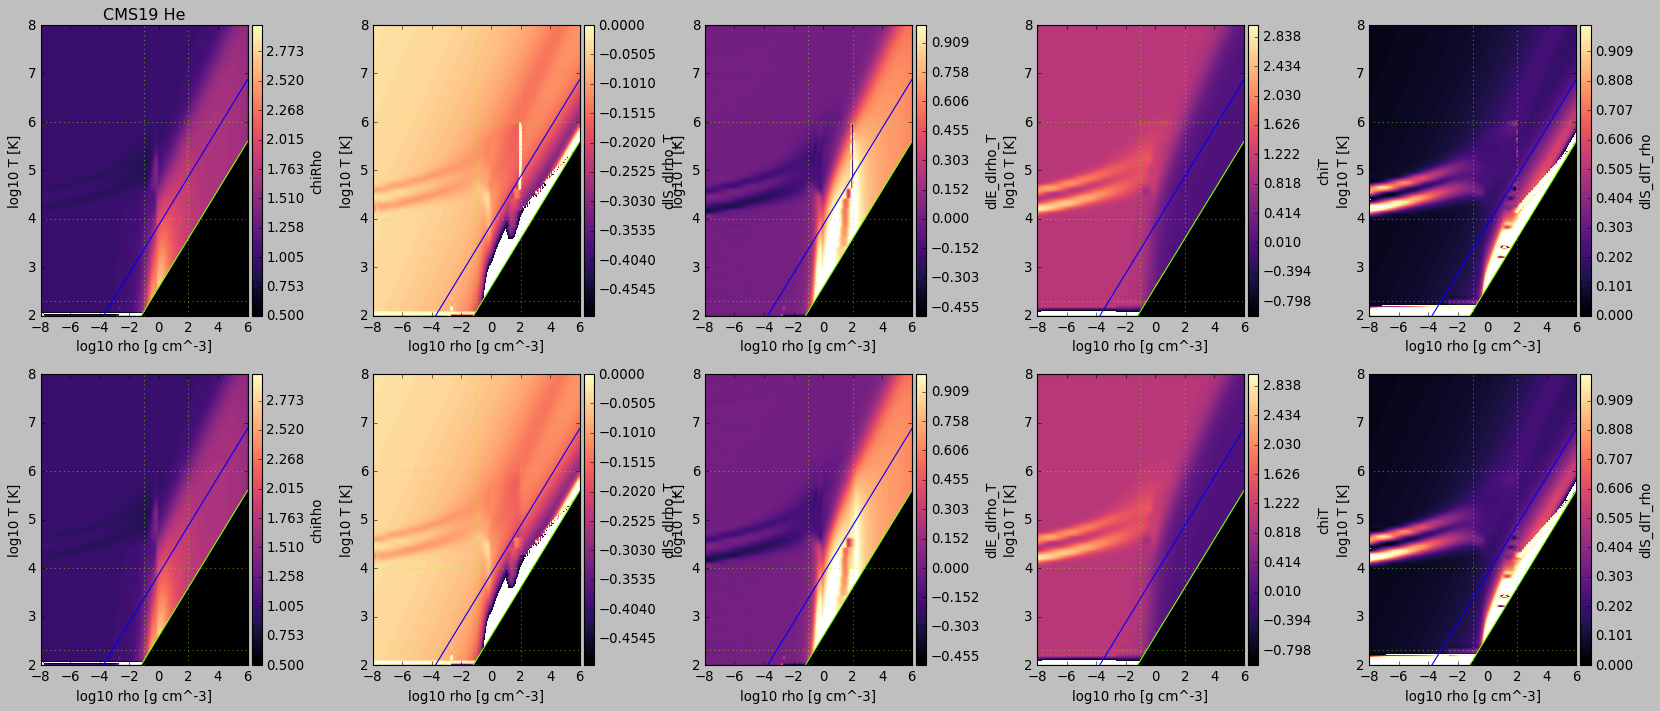

In [13]:
chiRho_vmin = 0.5
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -0.5
dlS_dlrho_T_vmax =0.#0.5
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -0.5
dlE_dlrho_T_vmax =1
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)


chiT_vmin = -1
chiT_vmax = 3
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = 0
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms19_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, cms19_He.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, cms19_He.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, cms19_He.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, cms19_He.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, cms19_He.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')



# row 1: interpolated finite difference quantities from cms19_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms19_He.log10rhogrid, cms19_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms19_He.atomic_number) - (5./3)*np.log10(cms19_He.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms19_He.atomic_number) - (5./3)*np.log10(cms19_He.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("CMS19 He")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [14]:
cms19_He.chiRho = chiRho_smoothed
cms19_He.dlS_dlrho_T = dlS_dlrho_T_smoothed
cms19_He.dlE_dlrho_T = dlE_dlrho_T_smoothed
cms19_He.chiT = chiT_smoothed
cms19_He.dlS_dlT_rho = dlS_dlT_rho_smoothed

In [15]:
cms19_He.compute_F_table()
outfile = open("./cms19_He_interpolated_over_bad_columns.pkl","wb")
pickle.dump(cms19_He,outfile)
outfile.close()

/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:956: RuntimeWarning: invalid value encountered in log10
  self.F_log10Pgrid = np.log10(self.F_Pgrid)
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:957: RuntimeWarning: invalid value encountered in log10
  self.F_log10Sgrid = np.log10(self.F_Sgrid)
/Users/emily/Documents/astro/giant_planets/MESA_EoS/EOSutils/EOSutils/EOSutils.py:958: RuntimeWarning: invalid value encountered in log10
  self.F_log10Egrid = np.log10(self.F_Egrid)
